# FrugalBedrock

Learn how to implement FrugalGPT-style LLM cascades on top of Amazon Bedrock to fight hallucinations.

<img src="https://i.pinimg.com/originals/94/53/02/945302d3fb5d1219f2d53dca0eacb55c.gif" width="25%"/>

## Initial Setup

Install dependencies

In [1]:
!pip install -r requirements.txt

Import libraries

In [2]:
import os
import json

from operator import itemgetter
from typing import (
    Any,
    List,
    Tuple,
    TypedDict
)

# HuggingFace 🤗
from datasets import load_dataset
from transformers import pipeline

# LangChain Core 🦜🔗
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnableBranch,
    RunnablePassthrough
)

# LangChain AWS ☁️
from langchain_aws import ChatBedrock

# LangGraph 🦜🕸️
from langgraph.graph import StateGraph, END

## Scoring Function

Reference: [Automating Hallucination Detection: Introducing the Vectara Factual Consistency Score](https://vectara.com/blog/automating-hallucination-detection-introducing-vectara-factual-consistency-score/)

In [3]:
hallucination_detector = pipeline(
    task="text-classification",
    model="vectara/hallucination_evaluation_model"
)

In [4]:
def scorer(inpt: dict) -> float:
    """
    Returns a score between 0 and 1 indicating whether the model is hallucinating.
    """
    result = hallucination_detector({'text': inpt['context'], 'text_pair': inpt['answer']})
    return result['score']  # 0 -> hallucination,  1 -> factually consistent

In [5]:
def batch_scorer(inpts: List[dict]) -> List[float]:
    """
    Scores multiple inputs in one go.
    """
    inputs = list(map(lambda inpt: {'text': inpt['context'], 'text_pair': inpt['answer']}, inpts))
    results = hallucination_detector(inputs)
    return list(map(lambda result: result['score'], results))

In [6]:
scorer({
    'context': "A person on a horse jumps over a broken down airplane.",
    'answer': "A person is outdoors, on a horse."
})

0.9963929057121277

In [7]:
scorer({
    'context': "A person on a horse jumps over a broken down airplane.",
    'answer': "A person is at a diner, ordering an omelette."
})

0.00047493731835857034

## LLM Chain

### LangChain

In [8]:
def build_chain(model_id: str, threshold: float, scoringf: callable = scorer):
    """
    Creates a model chain for question answering.
    """
    prompt = ChatPromptTemplate.from_template("{context}\n\n{question}")
    llm = ChatBedrock(model_id=model_id, model_kwargs={'temperature': 0})
    output_parser = StrOutputParser()
    return RunnableParallel({
        'context': itemgetter('context'),
        'question': itemgetter('question'),
        'model': lambda _: model_id,
        'answer': prompt | llm | output_parser
    }) | RunnableParallel({
        'context': itemgetter('context'),
        'question': itemgetter('question'),
        'model': itemgetter('model'),
        'answer': itemgetter('answer'),
        'score': RunnableLambda(scoringf),
        'threshold': lambda _: str(threshold)
    })

### LangGraph

In [9]:
def build_chain_lg(model_id: str):
    """
    Creates a model chain for question answering (LangGraph version).
    """
    prompt = ChatPromptTemplate.from_template("{context}\n\n{question}")
    llm = ChatBedrock(model_id=model_id, model_kwargs={'temperature': 0})
    output_parser = StrOutputParser()
    return RunnableParallel({
        'context': itemgetter('context'),
        'question': itemgetter('question'),
        'model': lambda _: model_id,
        'answer': prompt | llm | output_parser
    })

## LLM Cascade

### LangChain

In [10]:
def llm_cascade(model_ids: List[str], thresholds: List[float]):
    """
    Creates a static LLM cascade for question answering.
    """
    if len(model_ids) != len(thresholds):
        raise ValueError("The list of models and thresholds must have the same size.")

    def check_score(output):
        score = float(output['score'])
        threshold = float(output['threshold'])
        if score < threshold:
            return True
        return False

    chains = [
        build_chain(model_id, threshold) for model_id, threshold in zip(model_ids, thresholds)
    ]

    llmc = chains[0]
    for chain in chains[1:]:
        llmc = llmc | RunnableBranch(
            (lambda output: check_score(output), chain),  # pylint: disable=unnecessary-lambda
            RunnablePassthrough()
        )

    return llmc

### LangGraph

In [11]:
class ModelState(TypedDict):
    """
    State class to pass the model output along the sequence.
    """
    context: str
    question: str
    model: str
    answer: str

In [12]:
def llm_cascade_lg(model_ids: List[str], thresholds: List[float], scoringf: callable = scorer):
    """
    Creates a static LLM cascade for question answering (LangGraph version).
    """
    if len(model_ids) != len(thresholds):
        raise ValueError("The list of models and thresholds must have the same size.")

    def check_score(state: ModelState):
        if scoringf(state) < thresholds[model_ids.index(state['model'])]:
            return "next_model"
        return "end"

    graph = StateGraph(ModelState)
    for i, model_id in enumerate(model_ids):
        graph.add_node(model_id, build_chain_lg(model_id))
        if i < len(model_ids) - 1:
            graph.add_conditional_edges(model_id, check_score, {
                'next_model': model_ids[i+1],
                'end': END
            })
        else:
            graph.add_edge(model_ids[-1], END)
    graph.set_entry_point(model_ids[0])

    return graph.compile()

## Cost Tracking 💰

In [13]:
if os.path.isfile("pricing.json"):
    with open("pricing.json", encoding="utf-8") as f:
        BEDROCK_PRICING = json.load(f)
else:
    BEDROCK_PRICING = None

In [14]:
def compute_cost(response: dict, models: List) -> Tuple[float, float]:
    """
    Returns the actual cost of running the chain and the
    predicted cost if we were to use only the best model.
    """
    end_model = response['model']
    query = response['context'] + response['question']
    answer = response['answer']

    # Assumption: 1 token ~ 4 chars
    in_tokens = len(query) // 4
    out_tokens = len(answer) // 4

    cost = 0
    for model in models:
        model_pricing = BEDROCK_PRICING[model]
        cost += (in_tokens/1000)*model_pricing.get('input', 0.0) + \
                (out_tokens/1000)*model_pricing.get('output', 0.0)
        if model == end_model:
            break

    # Assumption: output tokens (LLM cascade) == # output tokens (best model)
    best_model_pricing = BEDROCK_PRICING[models[-1]]
    best_cost = (in_tokens/1000)*best_model_pricing.get('input', 0.0) + \
                (out_tokens/1000)*best_model_pricing.get('output', 0.0)

    return cost, best_cost

## Dataset

Reference: [Stanford Question Answering Dataset (SQuAD)](https://huggingface.co/datasets/rajpurkar/squad)

In [15]:
squad = load_dataset("squad", split="train[:10]")

In [16]:
squad = squad.train_test_split(test_size=0.2, seed=42)

In [17]:
def test_llm_cascade(llmc: Any, dataset: List[dict]):
    """
    Invokes the LLM cascade against a collection of context/question pairs
    and returns the final answer and a cost analysis.
    """
    for sample in dataset:
        response = llmc.invoke({'context': sample['context'], 'question': sample['question']})
        print(json.dumps(response, indent=4))
        cost, best_cost = compute_cost(response, models)
        cost_delta = (cost - best_cost) * 100 / best_cost
        print(f"Cost: ${cost} ({cost_delta:+.2f}%)\n")

## Evaluation

In [18]:
models = [
    "mistral.mistral-7b-instruct-v0:2",
    "mistral.mixtral-8x7b-instruct-v0:1",
    "anthropic.claude-3-haiku-20240307-v1:0",
    "anthropic.claude-3-sonnet-20240229-v1:0"
]

In [19]:
thresholds = [
    0.9,
    0.8,
    0.7,
    0.0
]

### LangChain

In [20]:
llmc_lc = llm_cascade(models, thresholds)

In [21]:
# Test
test_llm_cascade(llmc_lc, squad['train'])

{
    "context": "Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend \"Venite Ad Me Omnes\". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",
    "question": "To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?",
    "model": "mistral.mixtral-8x7b-instruct-v0:1",
    "answer": " The Virgin Mary, according to the Catholic faith, allegedly appeared to Saint Bernadette Soubirous in 1858 in Lourdes, Franc

### LangGraph

In [22]:
llmc_lg = llm_cascade_lg(models, thresholds)

In [23]:
llmc_lg.get_graph().print_ascii()

                                                                                           +-----------+                                                                      
                                                                                           | __start__ |                                                                      
                                                                                           +-----------+                                                                      
                                                                                                 *                                                                            
                                                                                                 *                                                                            
                                                                                                 *                           

In [24]:
print(llmc_lg.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	mistral_mistral-_b-instruct-v___([_]):::otherclass;
	mistral_mixtral-_x_b-instruct-v___([_]):::otherclass;
	anthropic_claude-_-haiku-________-v___([_]):::otherclass;
	anthropic_claude-_-sonnet-________-v___([_]):::otherclass;
	__start__ --> mistral_mistral-_b-instruct-v___;
	anthropic_claude-_-sonnet-________-v___ --> __end__;
	mistral_mistral-_b-instruct-v___ -. next_model .-> mistral_mixtral-_x_b-instruct-v___;
	mistral_mistral-_b-instruct-v___ -. end .-> __end__;
	mistral_mixtral-_x_b-instruct-v___ -. next_model .-> anthropic_claude-_-haiku-________-v___;
	mistral_mixtral-_x_b-instruct-v___ -. end .-> __end__;
	anthropic_claude-_-haiku-________-v___ -. next_model .-> anthropic_claude-_-sonnet-________-v___;
	anthropic_claude-_-haiku-________-v___ -. end .-> __end__;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#f

In [25]:
!pip install pygraphviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



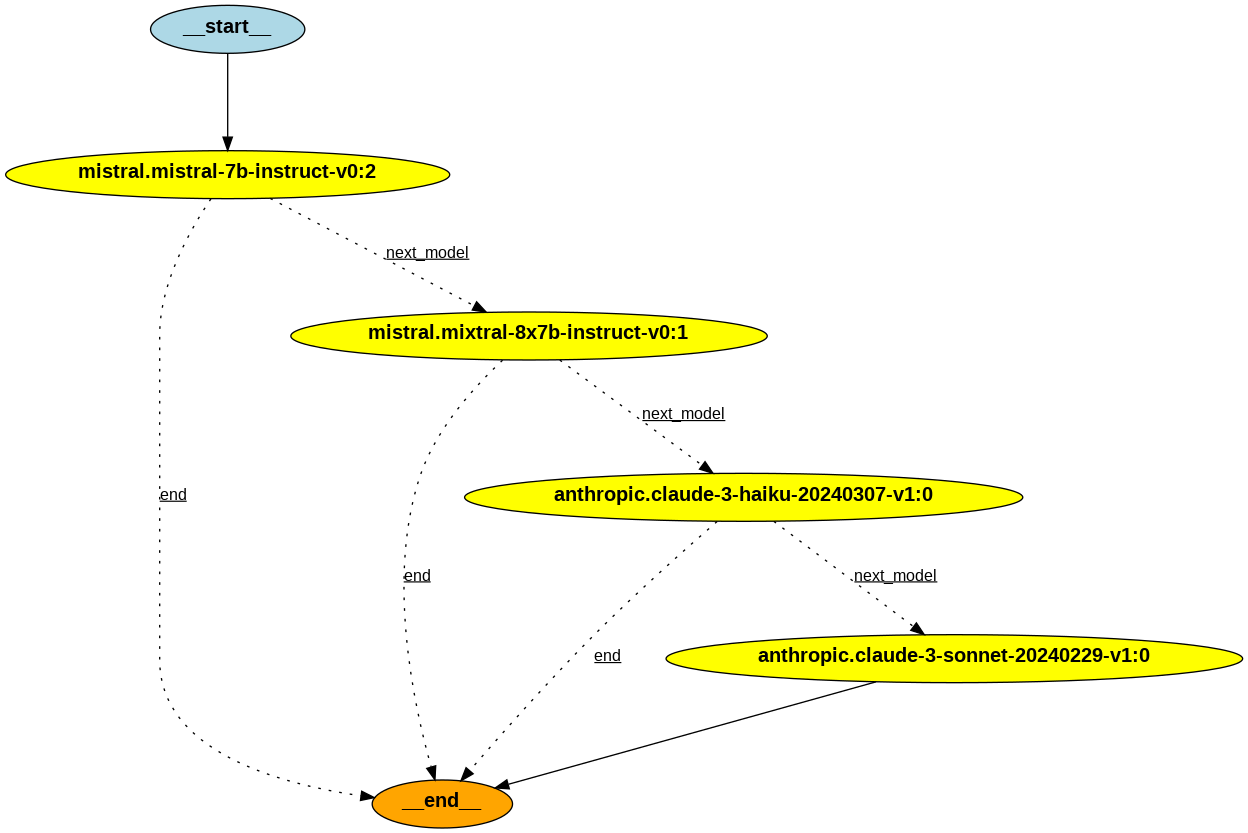

In [26]:
from IPython.display import display, HTML
import base64

def display_image(image_bytes: bytes, width=700):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))

display_image(llmc_lg.get_graph().draw_png())

In [27]:
# Test
test_llm_cascade(llmc_lg, squad['train'])

{
    "context": "Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend \"Venite Ad Me Omnes\". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",
    "question": "To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?",
    "model": "mistral.mixtral-8x7b-instruct-v0:1",
    "answer": " The Virgin Mary, according to the Catholic faith, allegedly appeared to Saint Bernadette Soubirous in 1858 in Lourdes, Franc